In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler

import lightning.pytorch as pl
from lightning.pytorch import Trainer

In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "Data/Tiny shakespeare/input.txt")

In [3]:
with open(data_dir, 'r') as f:
    text = f.read()

In [4]:
vocab = sorted(list(set(text)))
vocab_size = len(sorted(list(set(text)))) 
data_size = len(text)
# Hyperparameters
batch_size = 100 #B
block_size = 200 #T
emb_size = 1024 #C
num_blocks = 4
num_heads = 32
head_size = 1024
dropout = 0.1

if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"


In [5]:
token_encodings = {}
token_decodings = {}
for i, token in enumerate(vocab):
    token_encodings[token] = i
    token_decodings[i] = token

In [6]:
def encode(txt):
    enc_char = [token_encodings[char] for char in txt]
    return enc_char

def decode(enc_tokens):
    dec_char = [token_decodings[idx] for idx in enc_tokens]
    decoded_str = "".join(dec_char)
    return decoded_str

def generate_batch(batch_size, block_size):
    idx = torch.randint(0, data_size - block_size - 1, (batch_size,))
    data = torch.tensor(
        [encode(text[i : i + block_size]) for i in idx], device=device
    ) # B x T 
    targets = torch.tensor(
        [encode(text[i + 1 : i + block_size + 1]) for i in idx], device=device
    ) # B x T 
    return data, targets

In [7]:
data, targets = generate_batch(batch_size, block_size)
# print([decode(data[i].cpu().numpy()) for i in range(data.shape[0])])

In [8]:
class ShakespeareDataset(Dataset):
    def __init__(self, data_dir, train=True):
        super().__init__()
        self.dataset = open(data_dir, 'r').read()
        # train_dataset, val_dataset = torch.utils.data.random_split(self.data, [int(len(self.data) * 0.8), len(self.data) - int(len(self.data) * 0.8)])
        # if train:
        #     self.dataset = train_dataset
        # else:
        #     self.dataset = val_dataset
    
    def __getitem__(self, idx):
        # idx = torch.randint(0, data_size - block_size - 1, (batch_size,))
        data = torch.tensor(
            encode(self.dataset[idx : idx + block_size]), device=device
        ) # B x T 
        targets = torch.tensor(
            encode(self.dataset[idx + 1 : idx + block_size + 1]), device=device
        ) # B x T 
        return data, targets
    
    def __len__(self):
        return len(self.dataset)

In [9]:
dataset = ShakespeareDataset(data_dir)
sampler = DistributedSampler(dataset, num_replicas=1, rank=0)
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size
        self.q = nn.Linear(emb_size, self.head_size, device=device)
        self.k = nn.Linear(emb_size, self.head_size, device=device)
        self.v = nn.Linear(emb_size, self.head_size, device=device)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
#         print(x.device)
        q = self.q(x) # B, T, C -> B, T, H
        k = self.k(x)
        v = self.v(x)
        B, T, H = q.shape
        wei = q @ k.transpose(-1, -2) / np.sqrt(self.head_size) # B, T, H @ B, H, T -> B, T, T
        # print(wei.shape)
        mask = torch.tril(torch.ones(B, T, T)).to(x.device)
        wei = wei.masked_fill(mask == 0, float('-inf'))
        wei = nn.functional.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v # B, T, H  
        return out

In [11]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, emb_size):
        super().__init__()
        self.n_heads = n_heads
        self.emb_size = emb_size
        self.head_size = emb_size // n_heads
        self.linear = nn.Sequential(nn.Linear(emb_size,4 * emb_size), nn.ReLU(), nn.Linear(4 * emb_size, emb_size), nn.Dropout(0.2),)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = []
        for i in range(self.n_heads):
            att_head = SelfAttention(self.head_size)
            out.append(att_head(x))
        # print(len(out), out[0].shape)
        logits = torch.cat(out, dim=-1)
        logits = self.linear(logits)
        return logits


In [22]:
class FeedForwardBlock(nn.Module):
    def __init__(self, num_blocks, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.mha = MultiHeadedAttention(num_heads, emb_size)
        self.ff_net = nn.Sequential(
            nn.Linear(emb_size, emb_size * 4),
            nn.LeakyReLU(),
            nn.Linear(emb_size * 4, emb_size),
            nn.Dropout(dropout)
        )
        self.layer_norm_1 = nn.LayerNorm(emb_size)
        self.layer_norm_2 = nn.LayerNorm(emb_size)

    def forward(self, x):
        x = x + self.mha(self.layer_norm_1(x)) # B, T, C
        x = x + self.ff_net(self.layer_norm_2(x)) # B, T, vocab_size
        return x
        

In [13]:
class GPT(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_emb_table = nn.Embedding(vocab_size, emb_size, device=device)
        self.pos_emb_table = nn.Embedding(block_size, emb_size, device=device)
        # self.ff_net = nn.Linear(emb_size, emb_size, device=device)
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.head_size = head_size
        # self.mha = MultiHeadedAttention(self.num_heads)
        # self.layer_norm = nn.LayerNorm(emb_size, device=device, dtype=torch.float32)
        self.final_ll = nn.Linear(emb_size, vocab_size, device=device)
        self.blocks = nn.Sequential(
            *[FeedForwardBlock(num_blocks, num_heads) for i in range(num_blocks)]
        )
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, betas=(0.9, 0.95))

        dataset = ShakespeareDataset(data_dir)
        sampler = DistributedSampler(dataset, num_replicas=1, rank=0, shuffle=True)
        self.dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    def forward(self, x, targets=None):
        token_emb = self.token_emb_table(x) # B, T, C
        # print(x.shape, token_emb.shape)
        pos_emb = self.pos_emb_table(torch.arange(x.shape[-1], device=device)) # T, C
        x = token_emb + pos_emb # B, T, C
#         for _ in range(num_blocks):
#             x_res = x
#             x = self.layer_norm(x)
#             x = self.mha(x) # B, T, C
# #             x = x_res + x
# #             x_res = x
#             x = x_res + self.ff_net(x) # B, T, vocab_size
        x = self.blocks(x)
        logits = self.final_ll(x)
        # print(logits.shape)
        B, T, C = logits.shape
        if targets is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            # targets = self.token_emb_table(targets)
            loss = loss_fn(logits.view(B*T, C), targets.view(B*T))
        else:
            loss = None
        
        return logits, loss
    
    def generate(self, idx, max_tokens):
        for _ in range(max_tokens):
            idx_slice = idx[:, -block_size:]
            logits, loss = self.forward(idx_slice)
            logits = logits[:, -1, :]
            probabs = nn.functional.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probabs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
            
        return decode(idx[0].tolist())


    def train(self, num_steps, batch_size):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, betas=(0.9, 0.95))
        loss_ar = []
        for step in range(num_steps):
            optimizer.zero_grad()
            data, targets = generate_batch(batch_size, block_size)
            logits, loss = self.forward(data, targets)
            loss_ar.append(loss.item())
            loss.backward()
            optimizer.step()
            if (step+1) % 10 == 0:
                print(f"Step {step}, loss {loss.item()}")
        return loss_ar
    
    def train_sd(self, num_epochs, batch_size):
        loss_ar = []
        for epoch in range(num_epochs):
            for step, (data, targets) in enumerate(iter(self.dataloader)):
                self.optimizer.zero_grad()
                logits, loss = self.forward(data, targets)
                loss_ar.append(loss.item())
                loss.backward()
                self.optimizer.step()
                if (step+1) % 10 == 0:
                    print(f"Step {step}, loss {loss.item()}")
        return loss_ar


In [17]:
gpt = GPT(vocab_size).to(device)

In [18]:
np.sum([p.numel() for p in gpt.parameters()])

67504193

In [19]:
logits, loss = gpt(data, targets)
generated = gpt.generate(torch.zeros((1,1), dtype=torch.long, device=device), max_tokens=120)

In [20]:
print(generated)



: dz'WupZG$STLBilto;Lq:u&,BqWH.eHzwtH;-e,lls3'.:dXGFmzrVe Tf;hOUIJq&-;E3k
d3q !bimsZVr-RCwNQCDr-N;CdwdQx!tcaiu rmW!XFhgl


In [ ]:
loss_ar = gpt.train_sd(10, batch_size=batch_size)

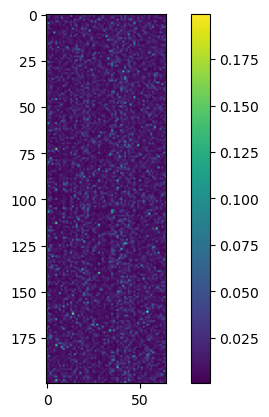

In [23]:
import matplotlib.pyplot as plt
plt.colorbar(plt.imshow(logits[0].softmax(-1).detach().cpu()))

In [23]:
class ShakespeareDataset_lightning(torch.utils.data.Dataset):
    def __init__(self, data_dir, train=True):
        super().__init__()
        total_data = open(data_dir, "r").read()
        train_data = total_data[:int(0.8*len(total_data))]
        val_data = total_data[int(0.8*len(total_data)):]
        if train:
            self.data = train_data
        else:
            self.data = val_data

    def __getitem__(self, idx):
        
        if (idx + block_size) >= len(self.data):
            idx = torch.randint(0, len(self.data) - block_size - 1, (1,))
            
        data = torch.tensor(
            self.encode(self.data[idx : idx + block_size])
        )  # T
        targets = torch.tensor(
            self.encode(self.data[idx + 1 : idx + block_size + 1])
        )  # T
#         return {"data":data, "targets":targets, "idx":idx}
        return data, targets

    def __len__(self):
        return len(self.data)
    
    def encode(self, txt):
        enc_char = [token_encodings[char] for char in txt]
        return enc_char

    def decode(self, enc_tokens):
        dec_char = [token_decodings[idx] for idx in enc_tokens]
        decoded_str = "".join(dec_char)
        return decoded_str
    

In [24]:
class ShakespeareDataLoader(DataLoader):
    
    def __init__(self, dataset, batch_size, shuffle, num_workers, batch_sampler=None, **kwargs):
        
        if batch_sampler is None:
            super().__init__(
                dataset=dataset,
                batch_size=batch_size, 
                shuffle=shuffle,
                num_workers=num_workers,
                collate_fn=self.collate_fn,
            )
        else:
            super().__init__(
                dataset=dataset,
                batch_size=batch_size,
                batch_sampler=batch_sampler,
                collate_fn=self.collate_fn,
            )
    
    def collate_fn(self, batch):
        # batch --> tuple --> B x T x 2
        data = torch.stack([batch[i][0] for i in range(len(batch))])
        targets = torch.stack([batch[i][1] for i in range(len(batch))])
        return data, targets
        

In [25]:
class ShakespeareDataModule(pl.LightningDataModule):
    
    def __init__(self, data_dir, batch_size, block_size):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.block_size = block_size
        print("initialised")
    
    def prepare_data(self):
        pass
    
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            dataset = ShakespeareDataset_lightning(self.data_dir)
            self.train_dataset = ShakespeareDataset_lightning(self.data_dir, train=True)
            self.val_dataset = ShakespeareDataset_lightning(self.data_dir, train=False)
            print("Train and Valid Dataset Loaded")
#         self.train_sampler = RandomSampler(self.train_dataset)
#         self.val_sampler = RandomSampler(self.val_dataset)
        self.train_sampler = None
        self.val_sampler = None
    
    def train_dataloader(self):
        assert self.train_dataset is not None, "Train Dataset is None"
        
        data_loader =  ShakespeareDataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=1,
            batch_sampler=self.train_sampler,
        )
        return data_loader
    
    def val_dataloader(self):
        assert self.val_dataset is not None, "Valid Dataset is None"
        
        data_loader =  ShakespeareDataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=1,
            batch_sampler=self.val_sampler,
        )
        return data_loader

In [26]:
class GPTLightning(pl.LightningModule):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_emb_table = nn.Embedding(vocab_size, emb_size).to("cuda")
        self.pos_emb_table = nn.Embedding(block_size, emb_size).to("cuda")
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.head_size = head_size
        self.final_ll = nn.Linear(emb_size, vocab_size)
        self.blocks = nn.Sequential(
            *[FeedForwardBlock(num_blocks, num_heads) for i in range(num_blocks)]
        )

    def forward(self, x, targets=None):
        # x: B, T
        token_emb = self.token_emb_table(x) # B, T, C
        # print(x.shape, token_emb.shape)
        B, T = x.shape
        positions = torch.arange(T, device=x.device)
#         print("x_device: ", x.device)
        pos_emb = self.pos_emb_table(positions) # T, C
        x = token_emb + pos_emb # B, T, C
        x = self.blocks(x)
        logits = self.final_ll(x)
        # print(logits.shape)
        B, T, C = logits.shape
        if targets is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(B*T, C), targets.view(B*T))
        else:
            loss = None
        
        return logits, loss

    def training_step(self, batch, batch_idx):
        data, targets = batch
#         data = encode(data)
#         targets = encode(targets)
        logits, loss = self.forward(data, targets)
        print(f"Train Batch_idx {batch_idx}; loss: {loss.item()}")
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
#     def validation_step(self, batch, batch_idx):
#         # loss_ar = []
#         data, targets = batch
# #         data = encode(data)
# #         targets = encode(targets)
#         logits, loss = self.forward(data, targets)
#         # loss_ar.append(loss.item())
#         print(f"Val Batch_idx {batch_idx}; loss: {loss.item()}")
#         return loss
    
    def generate(self, idx, max_tokens):
        for _ in range(max_tokens):
            idx_slice = idx[:, -block_size:]
            logits, loss = self.forward(idx_slice)
            logits = logits[:, -1, :]
            probabs = nn.functional.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probabs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return decode(idx[0].tolist())
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-5, betas=(0.9, 0.999))
        return optimizer


In [27]:
def print_memory():
    # Get memory usage of the tensor
    curr_memory_used = torch.cuda.memory_allocated("cuda") / (1024 * 1024)  # in MB
    max_memory_used = torch.cuda.max_memory_allocated("cuda") / (1024 * 1024)  # in MB
    return round(curr_memory_used, 2), round(max_memory_used, 2)
print_memory()

(1030.65, 11964.47)

In [28]:
gpt_l = GPTLightning(vocab_size)
shakespeare_dm = ShakespeareDataModule(data_dir=data_dir, 
                                       batch_size=batch_size, 
                                       block_size=block_size
                                      )


initialised


In [29]:
trainer = Trainer(accelerator="gpu", 
                  max_epochs=2, 
                  val_check_interval=0.01,
                  overfit_batches=0,
                  limit_val_batches=10,
                  num_sanity_val_steps=0,
                  devices=1,
#                   strategy="deepspeed_stage_3",
#                   precision=16,
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(gpt_l, datamodule=shakespeare_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | token_emb_table | Embedding  | 66.6 K
1 | pos_emb_table   | Embedding  | 204 K 
2 | final_ll        | Linear     | 66.6 K
3 | blocks          | Sequential | 67.2 M
-----------------------------------------------
67.5 M    Trainable params
0         Non-trainable params
67.5 M    Total params
270.017   Total estimated model params size (MB)


Train and Valid Dataset Loaded


Training: 0it [00:00, ?it/s]

Train Batch_idx 0; loss: 4.559771537780762
Train Batch_idx 1; loss: 3.9104247093200684
Train Batch_idx 2; loss: 3.64923095703125
Train Batch_idx 3; loss: 3.4803383350372314
Train Batch_idx 4; loss: 3.3371777534484863
Train Batch_idx 5; loss: 3.258852005004883
Train Batch_idx 6; loss: 3.1910417079925537
Train Batch_idx 7; loss: 3.142240047454834
Train Batch_idx 8; loss: 3.0918996334075928
Train Batch_idx 9; loss: 3.0998451709747314
Train Batch_idx 10; loss: 3.005330801010132
Train Batch_idx 11; loss: 3.010225534439087
Train Batch_idx 12; loss: 2.95318603515625
Train Batch_idx 13; loss: 2.942155122756958
Train Batch_idx 14; loss: 2.9245452880859375
Train Batch_idx 15; loss: 2.9111521244049072
Train Batch_idx 16; loss: 2.8774960041046143
Train Batch_idx 17; loss: 2.833667755126953
Train Batch_idx 18; loss: 2.823833703994751
Train Batch_idx 19; loss: 2.8189663887023926
Train Batch_idx 20; loss: 2.821383476257324
Train Batch_idx 21; loss: 2.7944419384002686
Train Batch_idx 22; loss: 2.77042

In [ ]:
print(gpt_l.generate(idx=torch.zeros((1,1), device=gpt_l.device, dtype=torch.long) ,max_tokens=100))

In [ ]:
with torch.no_grad():
    tl = shakespeare_dm.train_dataloader()
    batch = next(iter(tl))
    batch.to("cuda")
    logits, loss = gpt_l.training_step(batch)

    plt.colorbar(plt.imshow(logits[0].softmax(dim=-1).detach().cpu().numpy()))